In [1]:
# %% [markdown]
# ### 1. Import Libraries

# %%
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import Session, Options
from qiskit_ibm_runtime import QiskitRuntimeService

# %% [markdown]
# ### 2. Load and Preprocess Data

# %%
# Load the dataset
heart_df = pd.read_csv('datasets/heart.csv', delimiter=',')
heart_df.head()

# Convert categorical columns to strings
string_col = heart_df.select_dtypes(include="object").columns
heart_df[string_col] = heart_df[string_col].astype("string")

# Encode categorical columns
label_encoders = {}
for column in heart_df.columns:
    if heart_df[column].dtype == 'string':
        le = LabelEncoder()
        heart_df[column] = le.fit_transform(heart_df[column])
        label_encoders[column] = le

# Create a copy of the dataframe for visualization
plot_df = heart_df.copy()

# %% [markdown]
# ### 3. Define a Function to Train and Evaluate Models

# %%
def evaluate_models(X, y, num_features, cross_validation_folds=2):
    """
    Train and evaluate classical and quantum models for a given number of features.
    """
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Naive Bayes": GaussianNB(),
        "SVM (Linear Kernel)": SVC(kernel="linear"),
        "SVM (RBF Kernel)": SVC(kernel="rbf"),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=32),
    }

    # Cross-validation and evaluation
    kf = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True, random_state=42)
    results = {}

    # Classical models
    for model_name, model in models.items():
        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            score = roc_auc_score(y_val, y_pred)
            fold_scores.append(score)

        results[model_name] = np.mean(fold_scores)
        print(f"{model_name} - Average ROC AUC Score: {results[model_name]:.4f}")

    # Quantum model
    feature_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=1)
    ansatz = RealAmplitudes(num_qubits=X.shape[1], reps=3)
    optimizer = COBYLA(maxiter=100)
    sampler = Sampler()

    quantum_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        vqc = VQC(
            sampler=sampler,
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
        )

        vqc.fit(X_train, y_train)
        score = vqc.score(X_val, y_val)
        quantum_scores.append(score)
        print(f"Fold {fold + 1} - Quantum VQC Score: {score:.4f}")

    quantum_avg_score = np.mean(quantum_scores)
    results["Quantum VQC"] = quantum_avg_score
    print(f"Quantum VQC - Average ROC AUC Score: {quantum_avg_score:.4f}")

    # Real Quantum computer
    # Set up runtime options
    options = Options()
    options.execution.shots = 1024  # Number of shots
    options.optimization_level = 3  # Highest optimization level
    options.resilience_level = 1  # Enable basic error mitigation

    # Initialize VQC
    vqc = VQC(
        sampler=Sampler(),
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
    )
    service = QiskitRuntimeService(instance="ibm-q/open/main")
    backend = service.least_busy(operational=True, min_num_qubits=5)
    with Session(service=service, backend=backend):
        print("Training on real quantum hardware...")
        start_time = time.time()
        vqc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        # Evaluate the model
        train_score = vqc.score(X_train, y_train)
        test_score = vqc.score(X_val, y_val)
        print(f"Training Score: {train_score:.4f}")
        print(f"Test Score: {test_score:.4f}")
    results["Real Quantum VQC"]=test_score
    print(f"Real Quantum VQC - Average ROC AUC Score: {test_score:.4f}")

    return results

# %% [markdown]
# ### 4. Evaluate Models for Different Numbers of Features

# %%
# Define the number of features to test
feature_counts = [2, 3, 4, 5, 6]
all_results = {}

# Loop over feature counts
for num_features in feature_counts:
    print(f"\nEvaluating models with {num_features} features...")

    # Select top `num_features` based on correlation with the target
    target = "HeartDisease"
    corr = heart_df.corr()[target].abs().sort_values(ascending=False)
    selected_features = corr.index[1:num_features + 1].tolist()

    # Prepare the dataset with selected features
    X = heart_df[selected_features].values
    y = heart_df[target].values

    # Normalize features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Evaluate models
    results = evaluate_models(X, y, num_features)
    all_results[num_features] = results


Evaluating models with 2 features...
Logistic Regression - Average ROC AUC Score: 0.8096
Naive Bayes - Average ROC AUC Score: 0.8096
SVM (Linear Kernel) - Average ROC AUC Score: 0.8098
SVM (RBF Kernel) - Average ROC AUC Score: 0.8064
K-Nearest Neighbors - Average ROC AUC Score: 0.8096
Fold 1 - Quantum VQC Score: 0.8170
Fold 2 - Quantum VQC Score: 0.8017
Training on real quantum hardware...
Training completed in 43.04 seconds.
Training Score: 0.8257
Test Score: 0.8017
Quantum VQC - Average ROC AUC Score: 0.8094

Evaluating models with 3 features...
Logistic Regression - Average ROC AUC Score: 0.8100
Naive Bayes - Average ROC AUC Score: 0.7745
SVM (Linear Kernel) - Average ROC AUC Score: 0.8098
SVM (RBF Kernel) - Average ROC AUC Score: 0.8052
K-Nearest Neighbors - Average ROC AUC Score: 0.8058
Fold 1 - Quantum VQC Score: 0.8235
Fold 2 - Quantum VQC Score: 0.8105
Training on real quantum hardware...
Training completed in 70.19 seconds.
Training Score: 0.8083
Test Score: 0.8083
Quantum VQ

In [2]:
all_results

{2: {'Logistic Regression': 0.8096024582293067,
  'Naive Bayes': 0.8096024582293067,
  'SVM (Linear Kernel)': 0.8098137123103515,
  'SVM (RBF Kernel)': 0.806371231035145,
  'K-Nearest Neighbors': 0.8096024582293067,
  'Quantum VQC': 0.8093681917211328,
  'Real Quantum VQC': 0.8017429193899782},
 3: {'Logistic Regression': 0.8100297676205108,
  'Naive Bayes': 0.774529479546764,
  'SVM (Linear Kernel)': 0.8098137123103515,
  'SVM (RBF Kernel)': 0.805151718840023,
  'K-Nearest Neighbors': 0.8057710773958133,
  'Quantum VQC': 0.8169934640522876,
  'Real Quantum VQC': 0.8082788671023965},
 4: {'Logistic Regression': 0.8076099481467256,
  'Naive Bayes': 0.8025590551181103,
  'SVM (Linear Kernel)': 0.8098137123103515,
  'SVM (RBF Kernel)': 0.8060927597464951,
  'K-Nearest Neighbors': 0.806371231035145,
  'Quantum VQC': 0.7636165577342048,
  'Real Quantum VQC': 0.7494553376906318},
 5: {'Logistic Regression': 0.8205108507777992,
  'Naive Bayes': 0.8142836566160937,
  'SVM (Linear Kernel)': 0.8

Model               Logistic Regression  Naive Bayes  SVM (Linear Kernel)  \
Number of Features                                                          
2                              0.809602     0.809602             0.809814   
3                              0.810030     0.774529             0.809814   
4                              0.807610     0.802559             0.809814   
5                              0.820511     0.814284             0.811504   
6                              0.835423     0.829753             0.826652   

Model               SVM (RBF Kernel)  K-Nearest Neighbors  Quantum VQC  \
Number of Features                                                       
2                           0.806371             0.809602     0.809368   
3                           0.805152             0.805771     0.816993   
4                           0.806093             0.806371     0.763617   
5                           0.814264             0.805963     0.750545   
6               

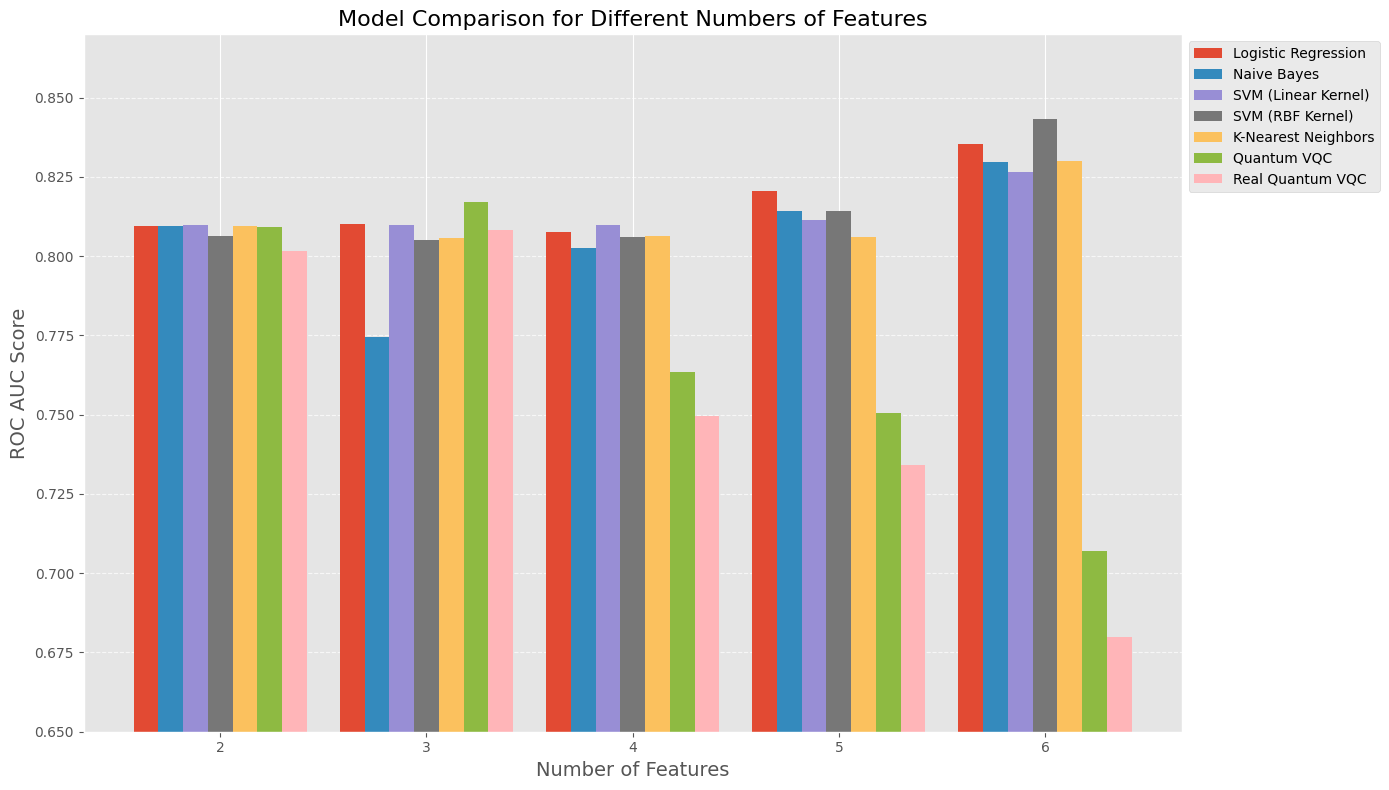

In [4]:
# Prepare data for visualization
model_names = list(all_results[2].keys())  # Get model names from the first result
feature_counts = list(all_results.keys())
scores = {model: [] for model in model_names}

for num_features in feature_counts:
    for model in model_names:
        scores[model].append(all_results[num_features].get(model, 0))

# Convert scores to a DataFrame for easier plotting
import pandas as pd

df_scores = pd.DataFrame(scores, index=feature_counts)
df_scores.index.name = "Number of Features"
df_scores.columns.name = "Model"
print(df_scores)

# Plot results as a grouped bar plot
plt.figure(figsize=(14, 8))
bar_width = 0.12
x = np.arange(len(feature_counts))

for i, model in enumerate(model_names):
    plt.bar(x + i * bar_width, df_scores[model], width=bar_width, label=model)

plt.title("Model Comparison for Different Numbers of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=14)
plt.ylim(0.65, 0.87)
plt.xticks(x + (len(model_names) - 1) * bar_width / 2, feature_counts)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()